In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
strong_benchmark_file = "out/strong_scaling_results.json"
weak_benchmark_file = "out/weak_scaling_results.json"

EXCLUDE_FIRST_N = 1

In [3]:
with open(weak_benchmark_file) as f:
    weak = json.load(f)

with open(strong_benchmark_file) as f:
    strong = json.load(f)


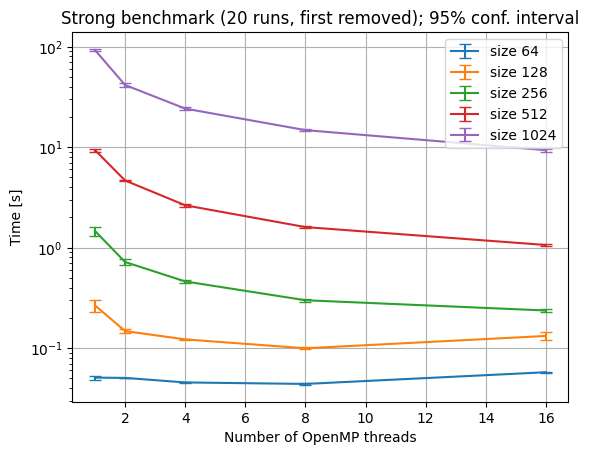

In [4]:
 # plot each threadcount as a line (different color) and each size as a point with error bars

# for each size plot time vs threads
for i, size in enumerate(strong["sizes"]):
    times_for_size = []

    # remove first n runs (warmup)
    for t in strong["times"][i]:
        times_for_size.append(t[EXCLUDE_FIRST_N:])

    values = []
    errors_y = []
    threads = strong["threads"]

    for t in times_for_size:
        # average
        values.append(sum(t) / len(t))
        # 95% confidence interval
        errors_y.append(1.96 * pd.Series(t).sem())      

    plt.errorbar(
        threads,
        values,
        yerr=errors_y,
        label=f"size {size}",
        capsize=4,
    )

plt.xlabel("Number of OpenMP threads")
plt.yscale("log")
plt.ylabel("Time [s]")
plt.grid()
plt.legend()

plt.title(f"Strong benchmark ({strong['runs']} runs, first removed); 95% conf. interval")

plt.savefig("../report/plots/strong_scaling.pdf")

plt.show()

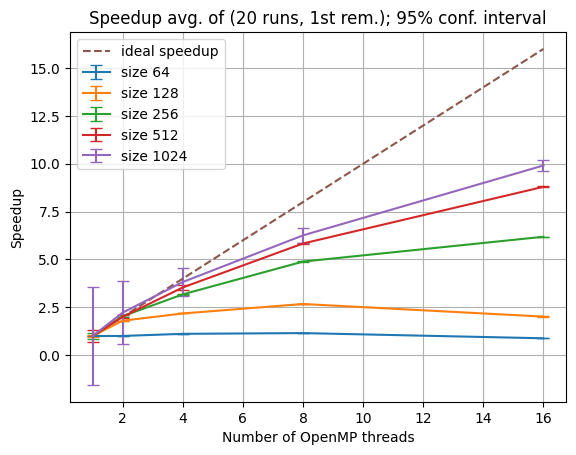

In [5]:
# plot speedup for each size

for i, size in enumerate(strong["sizes"]):

    times_for_size = []

    for t in strong["times"][i]:
        times_for_size.append(t[EXCLUDE_FIRST_N:])

    values = []
    errors_y = []
    threads = strong["threads"]

    for t in times_for_size:
        values.append(sum(t) / len(t))
        errors_y.append(1.96 * pd.Series(t).sem())

    # speedup
    speedup = [values[0] / v for v in values]

    plt.errorbar(
        threads,
        speedup,
        label=f"size {size}",
        yerr=errors_y,
        capsize=4,
    )

plt.plot(strong["threads"], strong["threads"], "--", label="ideal speedup")

plt.xlabel("Number of OpenMP threads")
plt.ylabel("Speedup")
plt.grid()
plt.legend()

plt.title(f"Speedup avg. of ({strong['runs']} runs, 1st rem.); 95% conf. interval")

plt.savefig("../report/plots/strong_speedup.pdf")

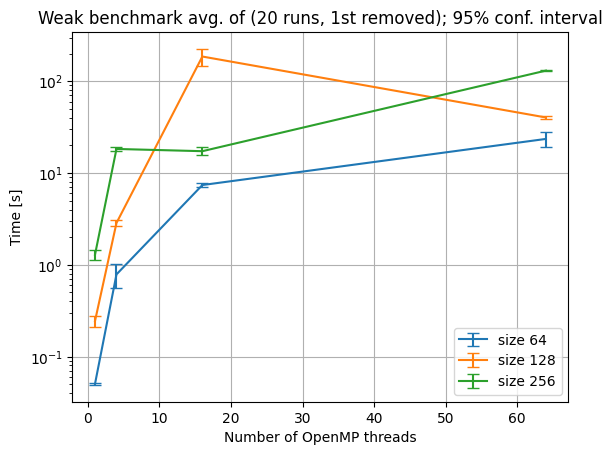

In [6]:
# weak scaling

for i, size in enumerate(weak["sizes"]):
    times_for_size = []

    for t in weak["times"][i]:
        times_for_size.append(t[EXCLUDE_FIRST_N:])

    values = []
    errors_y = []
    threads = weak["threads"]

    for t in times_for_size:
        values.append(sum(t) / len(t))
        errors_y.append(1.96 * pd.Series(t).sem())

    plt.errorbar(
        threads,
        values,
        yerr=errors_y,
        label=f"size {size}",
        capsize=4,
    )

plt.xlabel("Number of OpenMP threads")
plt.yscale("log")
plt.ylabel("Time [s]")
plt.grid()
plt.legend()

plt.title(f"Weak benchmark avg. of ({weak['runs']} runs, 1st removed); 95% conf. interval")

plt.savefig("../report/plots/weak_scaling.pdf")


[0.0013229118769331862, 0.2294853330684244, 0.2994521857992098, 4.354562613516572]
[0.0320984795986169, 0.23852629970109576, 38.965517671054236, 1.3670434737088544]
[0.16369593850739386, 0.7216658261134824, 1.6907916675006247, 2.67973944023453]


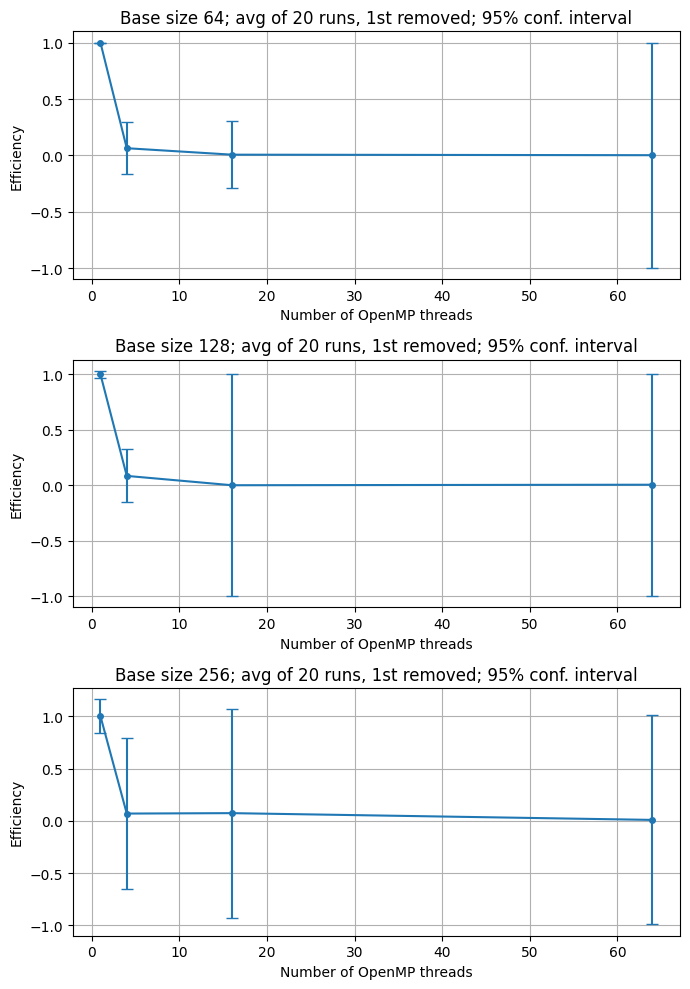

In [8]:
# plot efficiency

fig, axs = plt.subplots(len(weak["sizes"]), 1, figsize=(7, 10))

for i, size in enumerate(weak["sizes"]):

    ax = axs[i]

    times_for_size = []

    for t in weak["times"][i]:
        times_for_size.append(t[EXCLUDE_FIRST_N:])

    values = []
    errors_y = []
    threads = weak["threads"]

    base_time = sum(times_for_size[0]) / len(times_for_size[0])

    for t in times_for_size:
        values.append(base_time / (sum(t) / len(t)))
        errors_y.append(1.95 * pd.Series(t).sem())

    print(errors_y)

    # clamp error to 1
    errors_y = [min(1, e) for e in errors_y]

    ax.errorbar(
        threads,
        values,
        yerr=errors_y,
        label=f"size {size}",
        capsize=4,
        marker="o",
        markersize=4,
    )

    ax.set_xlabel("Number of OpenMP threads")
    ax.set_ylabel("Efficiency")
    # ax.set_yscale("log")
    ax.grid()
    # set title for each subplot
    ax.set_title(
        f"Base size {size}; avg of {weak['runs']} runs, 1st removed; 95% conf. interval")

fig.tight_layout()

plt.savefig("../report/plots/weak_efficiency.pdf")